In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import re
import os
from datetime import date
import mygene         #for alternative method of changing ensembl names to "normal" gene names
mg = mygene.MyGeneInfo()
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
def my_pca(df, n_pc=1, normalize=True):
    '''
    Function for performing the PCA, using sklearn. 
    
    df - Dataframe with expression values
    '''
    df = df.dropna(axis = 0, how = 'all') #Remove rows with only NA values. Should be none
    x = df.values.T #Set x as transpose of only the numerical values of the dataframe
    if normalize:
        x2 = preprocessing.scale(x) #Standardize the data (center to mean and scale to unit variance)
    else:
        x2 = x
    pca = PCA(n_components = n_pc) #Set PCA parameters
    pca.fit(x2) #Fit data to model
    expl = pca.explained_variance_ratio_
    x3 = pca.fit_transform(x2) #Transform the data (apply dimensionality reduciton) and set x3 as principal components 
    out_df = pd.DataFrame(x3.transpose(), index=list(range(1,n_pc+1)), columns=df.columns) #Create dataframe with vlues from the PCA and set columnindex as the PC number 
    out_df = out_df.transpose()
    return out_df, expl


def TFs_targets(kbp, chip): 
    '''
    Function for creating csv with all TFs and their target genes. For each TF, it identifies urls for target gene data, fetches the info and puts it into a list that is then converted to a dataframe as output
    '''
    TFrange = ('Target Genes (TSS }'+kbp+'k)')
    TF_gene_list = []
    dex = 0
    for url in chip.loc[:,TFrange]: #OBS! This takes a long time.
        try:
            TF_gene_set = pd.read_csv(url, sep='\t') #For a specific TF, read csv from url as a dataframe
            genes = TF_gene_set['Target_genes'].tolist() #Take the contents of column 'Target_genes' and puts it into a list
            TF_gene_list.append(genes) #Append the list for a specific TF to list with all TFs
            print('Genes for '+chip.index[dex]+' ('+str(dex)+') found')
        except: #If the url can't be reached, insert 'Not found' in the list and continue (to get correct index)
            genes = []
            TF_gene_list.append(genes) #Append empty list for TFs for whose genes were not found
            print('Genes for '+chip.index[dex]+' ('+str(dex)+') NOT found')
        dex = dex+1
    TF_gene_sets = pd.DataFrame({'Genes':TF_gene_list}, index=chip.index) #Create a dataframe from the list of TFs and their target genes
    TF_gene_sets.to_csv('../data/Transfactors/TF_gene_sets_'+kbp+'.tsv', sep='\t')
    return TF_gene_sets

def TFs_targets_strict(kbp, chip): 
    '''
    Function for creating csv with all TFs and a strict selection of their potential target genes. For each TF, 
    it identifies urls for target genedata, fetches the info and puts genes with a high enough MACS2 and STRING
    binding score into a list that is then converted to a dataframe as output
    '''
    TFrange = ('Target Genes (TSS }'+kbp+'k)')
    TF_gene_list = []
    dex = 0
    for url in chip.loc[:,TFrange]: #OBS! This takes a long time.
        try:
            TF_gene_set = pd.read_csv(url, sep='\t') #For a specific TF, read csv from url as a dataframe
            name = TF_gene_set.columns[1]
            genes = TF_gene_set.loc[(TF_gene_set > 250).sum(axis=1)>0,:].index.tolist() #Take the contents of column 'Target_genes' and puts it into a list for rows with a value above 250
            TF_gene_list.append(genes) #Append the list for a specific TF to list with all TFs
            print('Genes for '+chip.index[dex]+' ('+str(dex)+') found')
        except: #If the url can't be reached, insert 'Not found' in the list and continue (to get correct index)
            genes = []
            TF_gene_list.append(genes) #Append empty list for TFs for whose genes were not found or had too low score
            print('Genes for '+chip.index[dex]+' ('+str(dex)+') NOT found')
        dex = dex+1
    TF_gene_sets = pd.DataFrame({'Genes':TF_gene_list}, index=chip.index) #Create a dataframe from the list of TFs and their target genes
    TF_gene_sets.to_csv('../data/Transfactors/TF_gene_sets_'+kbp+'_strict.tsv', sep='\t')
    return TF_gene_sets


def ID_to_symbol(datatsv): 
    '''
    Function for replacing the ensenbl gene IDs with gene symbols/names in dataframe with expression data
    '''
    dataset = pd.read_csv(datatsv, sep='\t') 
    symbols = pd.read_csv('../data/Gene_names.txt', index_col='Gene stable ID')
    symbols = symbols.drop_duplicates(keep=False)
    dataset = dataset.merge(symbols, left_on='Gene', right_on='Gene stable ID', how = 'left')
    dataset.dropna(how='any', inplace=True)
    dataset.set_index('Gene name', inplace=True)
    dataset.drop(columns='Gene', inplace=True)
    dataset.index.rename('Symbol', inplace=True)
    dataset.to_csv('../data/genes.raw.htseq2.symbolsTEST.tsv', sep='\t')
    return dataset


def ID_to_symbolMG(datatsv):
    '''
    Alternative function for replacing the ensembl gene IDs with gene symbols/names in expression data, using MyGene package.
    '''
    dataset = pd.read_csv(datatsv, sep='\t')
    genes = dataset.loc[:,'Gene']
    genesyms = mg.querymany(genes, scopes='ensembl.gene', fields='symbol', as_dataframe=True) #Look up gene symbols with mygene
    genesyms = genesyms.dropna(subset=['symbol'], how='any') #Drop genes where no gene symbol was identified
    genesyms = genesyms.loc[~genesyms.index.duplicated(keep=False)] #Drop genes for which multiple gene symbols were identified
    syms = genesyms.loc[:,'symbol']
    dataset = dataset.merge(syms, left_on='Gene', right_on='query', how = 'left')
    dataset.dropna(how='any', inplace=True)
    dataset.set_index('symbol', inplace=True)
    dataset.index.rename('Symbol',inplace=True)
    dataset.drop(columns='Gene', inplace=True)
    dataset.to_csv('../data/genes.raw.htseq2.symbolsMG.tsv', sep='\t')
    return dataset

def csv_fix(csv):
    '''
    Function that opens a csv file and removes quotes at the end and beginning of rows with quotes in them,
    and converst double quotes to single quotes.
    (The original chip_atlas_analysis_list.csv that was downloaded did not work,
    as it contained an extra '"' in the start and end of each row with '"' in it, and each '"' had an extra  '"')
    '''
    name, ext = os.path.splitext(csv)
    newfilename = '{name}_{add}{ext}'.format(name=name, add='CORRECTED', ext='.csv')
    with open(csv,'r+') as csv_file:
        for line in csv_file:
            # removing starting and ending quotes of a line
            pattern1 = re.compile(r'^"|"$',re.MULTILINE)
            line = re.sub(r'^"|"$',"",line)
            # substituting escaped quote with a single quote
            pattern2 = re.compile(r'""')
            line = re.sub(r'""','"',line)
            corrected_csv = open(newfilename,'a')
            corrected_csv.write(line)
            corrected_csv.close()
    csv_df = pd.read_csv(newfilename, quotechar = '"')
    return csv_df

def indexing(dataset, dataset2):
    '''
    Function that creates a dataframe with multi-colunindex of organ and developmental stage, index is genes
    '''
    #Exctract important characteristincs of samples from dataset2
    chars = pd.DataFrame()
    chars['assay'] = dataset2.loc[:,'Assay Name'].str.slice(stop=6)
    #chars['dev_stage'] = dataset2.loc[:,'Characteristics[developmental stage]']
    chars['organ'] = dataset2.loc[:,'Characteristics[organism part]']
    chars = chars.drop_duplicates()
    chars['dev_stage'] = [-5.5,-5.5,-2.5,-2.5,0.5,0.5,4,4,22,22,29,29,-5.5,-5.5,-2.5,-2.5,0.5,0.5,4,4,22,22,29,29]
    chars = chars.set_index('assay')

    #Insert the important characteristics into dataset with expression values as column index
    datasetT = dataset.T
    datasetT['dev_stage'] = datasetT.index.to_series().map(chars['dev_stage'])
    datasetT['organ'] = datasetT.index.to_series().map(chars['organ'])
    datasetT.set_index(['organ','dev_stage'], inplace=True)
    #expdata = datasetT.sort_index(level = 0).T
    expdata = datasetT.T
    return expdata

def log2trans(expdata):
    '''
    Function that adds 1 to each value in the dataframe and log2 transforms the dataframe.
    Alternatively removes genes (rows) with 0 activity at any timepoint
    '''
    #expdata = expdata.loc[~(expdata<=0.0).any(axis=1)]
    expdata = expdata+1
    logdata = np.log2(expdata)
    display(logdata)
    return logdata

def run_my_pca(expdata, TF_gene_sets):
    '''
    Function that uses my_pca on supplied dataframe
    '''
    var_expl = []
    PCA_per_TF = pd.DataFrame(index=expdata.columns)
    for TF in TF_gene_sets.index: 
        genesIndex = pd.DataFrame(TF_gene_sets.loc[TF,'Genes'], columns=['Genes'])
        genesIndex.set_index('Genes', inplace=True)  
        genes = genesIndex.index.intersection(expdata.index)
        TFdata = expdata.loc[genes,:]
        [res, expl] = my_pca(TFdata)
        PCA_per_TF[TF] = res
        var_expl.append([TF,expl[0],len(genes)])

    df_var_expl = pd.DataFrame(var_expl, columns=['TF','Variance explained', 'Nr of genes'])
    df_var_expl = df_var_expl.set_index('TF')
    PCA_per_TF.sort_index(inplace=True)
    display(PCA_per_TF)
    display(df_var_expl)
    return PCA_per_TF, df_var_expl

def save_exp(data, filename):
    '''
    Save data from performed experiments as tsv file in a date-specific subfolder of exp
    '''
    if os.path.isdir('../exp/'+str(date.today())):
        data.to_csv('../exp/'+str(date.today())+'/'+filename+'.tsv', sep='\t')
    else:
        os.mkdir('../exp/'+str(date.today()))
        data.to_csv('../exp/'+str(date.today())+'/'+filename+'.tsv', sep='\t')

        
def save_fig(figure, TF, datatype):
    '''
    Save a figure as a png in a date-specific subfolder of exp
    '''
    if os.path.isdir('../exp/'+str(date.today())):
        figure.savefig('../exp/'+str(date.today())+'/'+TF+'_'+datatype+'_plot.png', bbox_inches="tight")
    else:
        os.mkdir('../exp/'+str(date.today()))
        figure.savefig('../exp/'+str(date.today())+'/'+TF+'_'+datatype+'_plot.png', bbox_inches="tight")


def ANOVA(PCA_per_TF):
    '''
    Perform ANOVA with statsmodels anova_lm for each TF separately and return a dataframe with p-values
    '''
    p_vals = pd.DataFrame(index=PCA_per_TF.T.index, columns=['C(organ)','C(dev_stage)','C(organ):C(dev_stage)'])
    for TF in p_vals.index:
        test_data = pd.DataFrame(PCA_per_TF.loc[:,TF])
        test_data = test_data.reset_index()
        test_data.columns = ["organ", "dev_stage", "TF_expr"]
        data = test_data
        TF_lm = ols('TF_expr ~ C(organ)+C(dev_stage)+C(organ):C(dev_stage)', data=data).fit()
        table = sm.stats.anova_lm(TF_lm, typ=2)
        p_vals.loc[TF,'C(organ)'] = table.iloc[0,3]
        p_vals.loc[TF,'C(dev_stage)'] = table.iloc[1,3]
        p_vals.loc[TF,'C(organ):C(dev_stage)'] = table.iloc[2,3]
        p_vals.index.name = 'TF'
    return p_vals

def my_pcaX(df, n_pc=1, normalize=True):
    '''
    Function for performing the PCA. Takes dataframe with expression values as input
    Additionally gives a dataframe with info of how much each gene contributes to the first PC

    '''
    df = df.dropna(axis = 0, how = 'all') #Remove rows with only NA values. Should be none
    x = df.values.T #Set x as transpose of only the numerical values of the dataframe
    if normalize:
        x2 = preprocessing.scale(x) #Standardize the data (center to mean and scale to unit variance)
    else:
        x2 = x
    pca = PCA(n_components = n_pc) #Set PCA parameters
    pca.fit(x2) #Fit data to model
    expl = pca.explained_variance_ratio_
    x3 = pca.fit_transform(x2) #Transform the data (apply dimensionality reduciton) and set x3 as principal components 
    out_df = pd.DataFrame(x3.transpose(), index=list(range(1,n_pc+1)), columns=df.columns) #Create dataframe with vlues from the PCA and set columnindex as the PC number 
    out_df = out_df.transpose()
    
    cont = pd.DataFrame(index=df.index, columns=['Contribution'])
    cont.loc[:,'Contribution'] = pca.components_[0]**2
    cont.sort_values(by='Contribution', ascending=False, inplace=True)

    #display(pca.components_[0])
    #display(pca.components_[0]**2)
    #most_important = np.argpartition(pca.components_[0]**2,-3)[-3:]
    #most_important_names = [df.index[most_important[0]]]
    #most_important_expl = pca.components_[0][most_important]**2
    #dic = [most_important_names[0], pca.components_[most_important]]
    #most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pc)]
    #most_important_names = [df.index[most_important[i]] for i in range(n_pc)]
    #dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pc)}
    #print(pd.DataFrame(dic.items()))
    #print(most_important_names)
    #print(most_important_expl)
    return out_df, expl, cont


def run_my_pcaX(expdata, TF_gene_sets):
    '''
    Runs my_pca on supplied dataframe
    Additionally plots the distribution for how much genes contribute to the first PC for selected TFs
    '''
    var_expl = []
    PCA_per_TF = pd.DataFrame(index=expdata.columns)
    for TF in TF_gene_sets.index: 
        genesIndex = pd.DataFrame(TF_gene_sets.loc[TF,'Genes'], columns=['Genes'])
        genesIndex.set_index('Genes', inplace=True)  
        genes = genesIndex.index.intersection(expdata.index)
        TFdata = expdata.loc[genes,:]
        if TF in ('Brf2', 'Foxa3'):
            [res,expl, cont] = my_pcaX(TFdata)
            bins = np.linspace(0,max(cont.loc[:,'Contribution']), 50)
            plt.hist(cont.loc[:,'Contribution'], bins)#, , alpha=0.5, label=variable)
            plt.xlabel('% contribution to PC1')
            plt.ylabel('Nr of genes')
            plt.title(TF)
            plt.show()
        else:
            [res, expl] = my_pca(TFdata)
        PCA_per_TF[TF] = res
        var_expl.append([TF,expl[0],len(genes)])

    df_var_expl = pd.DataFrame(var_expl, columns=['TF','Variance explained', 'Nr of genes'])
    df_var_expl = df_var_expl.set_index('TF')
    PCA_per_TF.sort_index(inplace=True)
    display(PCA_per_TF)
    display(df_var_expl)
    return PCA_per_TF, df_var_expl

def fetch_data(kbp):
    '''
    Fetch data on which genes may be regulated by each TF, the longitudinal mRNA expression data, and the sample specifications
    '''
    # Read csv with all all TFs and urls to files with their target genes
    try:
        chip = pd.read_csv('../data/Transfactors/chip_atlas_analysis_list_CORRECTED.csv').loc[1255:1953,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
    except FileNotFoundError:
        chip = csv_fix('../data/Transfactors/chip_atlas_analysis_list.csv').loc[1255:1953,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
    chip = chip.set_index('Antigen')

    #Read csv with TFs and their target genes. If not available, fetch the data and create a csv
    try: 
        TF_gene_sets = pd.read_csv('../data/Transfactors/TF_gene_sets_1.tsv', sep='\t', index_col='Antigen', converters={'Genes': lambda x: x.strip('[]').replace("'","").split(', ')})
        dropempty(TF_gene_sets, 'Genes', [])

    except FileNotFoundError:
        TF_gene_sets = TFs_targets(kbp, chip)
        dropempty(TF_gene_sets, 'Genes', [])

        
    #Read in dataset with expression values and gene symbols. If not available, replace ensembl IDs and create the csv
    try:
        dataset = pd.read_csv('../data/genes.raw.htseq2.symbols.tsv', sep='\t', index_col='Symbol')
    except:
        ID_to_symbol('../data/genes.raw.htseq2.tsv')

    #Read in dataset with sample sepcifications
    dataset2 = pd.read_csv('../data/E-MTAB-2328.sdrf.tsv', sep='\t') #Read csv with specifications of assays
    return TF_gene_sets, dataset, dataset2
    
def disthist (p_vals):
    '''
    Plot histogram for p-value distribution inlcluding all three tested groups
    '''
    for variable in p_vals.columns:
        bins = np.linspace(0,1, 50)
        plt.hist(p_vals.loc[:,variable], bins, alpha=0.5, label=variable)
    plt.legend(loc='upper right')
    plt.xlabel('p-value')
    plt.ylabel('Nr of TFs')
    plt.title('p-value histogram')
    save_fig(plt,'p-value','histogram')
    plt.show()
    
def lowp (p_vals):    
    '''
    Make and show dataframes with TFs with a p-value below Bonferroni corrected 0.05 for each of the groups tested
    '''
    for var in p_vals.columns:
        low_p_vals = p_vals.loc[p_vals[var]<(0.05/len(p_vals))]
        low_p_vals.sort_values(by=var, inplace=True)
        display(low_p_vals)
    return low_p_vals
        
def lowpplot (low_p_vals, PCA_per_TF,logdata):
    '''
    Function for plotting TF principal component and gene expression over time
    '''
    for TF in low_p_vals.index:
        #Plot the combined PC expression for TFs found to have a low p-valiue
        PC_plot = sns.relplot(x='dev_stage', y=TF, hue='organ', style='organ', kind='line', data=PCA_per_TF.reset_index())
        plt.xlabel('Developmental stage (days)')
        plt.ylabel('Log2 expression')
        plt.title(TF+' PC expression')
        save_fig(plt,TF,'PC')
        #Plot the gene expression for the TFs found to have a low p-value
        Gene_plot = sns.relplot(x='dev_stage', y=TF, hue='organ', style='organ', kind='line', data=logdata.T.sort_index().reset_index())
        plt.xlabel('Developmental stage (days)')
        plt.ylabel('Log2 expression')
        plt.title(TF+' gene expression')
        save_fig(plt,TF,'Gene')
    plt.show()
        
def main (kbp):
    #Fetch data of which genes may be regulated by specific TFs, longitudinal mRNA expression data, and sample classification data
    [TF_gene_sets, dataset, dataset2] = fetch_data(kbp)
    #Set index for expression data and log2 transform it
    expdata = indexing(dataset,dataset2)
    logdata = log2trans(expdata)
    #Run PCA on the prepared dataframe, giving the PC values for each TF and how much of the data the the first PC explains
    [PCA_per_TF, df_var_expl] = run_my_pcaX(logdata, TF_gene_sets)
    #Perform ANOVA
    p_vals = ANOVA(PCA_per_TF)
    #Plot the p-value distribution for differences between organs, developmental stages, and the combination of the two variables
    disthist(p_vals)
    #Pick out low p-values, based on Bonferroni multiple hypothesis corrected significance threshold of 0.05 
    low_p_vals = lowp(p_vals)
    #Plot the expression over time for TFs with low p-value, both their principal component and own gene expression data
    lowpplot(low_p_vals, PCA_per_TF, logdata)
    #Save the acquired results as tsv files
    save_exp(PCA_per_TF, 'PCA_results')
    save_exp(df_var_expl, 'Variance_explained')
    save_exp(p_vals,'p_vals')
    
def genesethist (TF_gene_sets):
    length = pd.DataFrame(index=TF_gene_sets.index, columns=['Genes'])
    len(TF_gene_sets.iloc[1,:][0])
    for TF in TF_gene_sets.index:
        length.loc[TF:,'Genes'] = len(TF_gene_sets.loc[TF,:][0])
    length.hist()
    
def dropempty(df, col, key):
    m = [v == key for v in df[col]]
    df.loc[m, col] = float('NaN')
    df.dropna(inplace=True)
    return df

In [3]:
# Read csv with all all TFs and urls to files with their target genes
try:
    chip = pd.read_csv('../data/Transfactors/chip_atlas_analysis_list_CORRECTED.csv').loc[1255:1953,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
except FileNotFoundError:
    chip = csv_fix('../data/Transfactors/chip_atlas_analysis_list.csv').loc[1255:1953,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
chip = chip.set_index('Antigen')

#Read csv with TFs and their target genes. If not available, fetch the data and create a csv
try: 
    TF_gene_sets = pd.read_csv('../data/Transfactors/TF_gene_sets_1.tsv', sep='\t', index_col='Antigen', converters={'Genes': lambda x: x.strip('[]').replace("'","").split(', ')})
    dropempty(TF_gene_sets, 'Genes', [])
except FileNotFoundError:
    TF_gene_sets = TFs_targets('1', chip)
    dropempty(TF_gene_sets, 'Genes', [])

#Read in dataset with expression values and gene symbols. If not available, replace ensembl IDs and create the csv
try:
    dataset = pd.read_csv('../data/genes.raw.htseq2.symbols.tsv', sep='\t', index_col='Symbol')
except:
    ID_to_symbol('../data/genes.raw.htseq2.tsv')

#Read in dataset with sample sepcifications
dataset2 = pd.read_csv('../data/E-MTAB-2328.sdrf.tsv', sep='\t') #Read csv with specifications of assays

In [ ]:
chip = pd.read_csv('../data/Transfactors/chip_atlas_analysis_list_CORRECTED.csv').loc[1255:1355,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
chip = chip.set_index('Antigen')

TF_gene_sets = TFs_targets_strict('1', chip)
dropempty(TF_gene_sets, 'Genes', [])

    
genesethist(TF_gene_sets)


Genes for Acaa2 (0) NOT found
Genes for Acss2 (1) NOT found
Genes for Actb (2) NOT found
Genes for Adnp (3) NOT found
Genes for Aebp2 (4) NOT found
Genes for Aff3 (5) NOT found
Genes for Aff4 (6) NOT found
Genes for Ahcy (7) NOT found
Genes for Ahr (8) NOT found
Genes for Aicda (9) NOT found
Genes for Aire (10) NOT found
Genes for Anp32e (11) NOT found
Genes for Ar (12) NOT found
Genes for Arid1a (13) NOT found
Genes for Arid3a (14) NOT found


In [5]:
#Set index for expression data and log2 transform it
expdata = indexing(dataset,dataset2)
logdata = log2trans(expdata)

organ            liver                 brain                 liver             \
dev_stage        -5.5       -5.5       -5.5       -5.5       -2.5       -2.5    
Symbol                                                                          
Gnai3        12.229119  10.685625  11.294046  10.476746  12.222795  11.764457   
Pbsn          0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
Cdc45         9.943980   8.400879   7.357552   6.768184   9.103288   8.939579   
H19          16.244364  14.945535  12.006326  10.863412  17.475726  17.104548   
Scml2         6.189825   4.700440   6.426265   5.781360   5.614710   5.285402   
...                ...        ...        ...        ...        ...        ...   
Vmn1r-ps47    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
Gm22396       0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
Gm22394       0.000000   0.000000   0.000000   0.000000   1.000000   0.000000   
Vmn1r-ps147   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
Methig1       0.000000   0.000000   0.000000   0.000000   0.000000   2.321928   

organ            brain                 liver             ...      brain  \
dev_stage        -2.5       -2.5        0.5        0.5   ...       4.0    
Symbol                                                   ...              
Gnai3        10.727070  11.295195  11.277287  10.153552  ...  11.246741   
Pbsn          0.000000   0.000000   0.000000   0.000000  ...   0.000000   
Cdc45         6.000000   6.507795   8.717676   7.665336  ...   6.643856   
H19          10.333155  11.711237  16.273267  16.137952  ...   8.658211   
Scml2         6.000000   6.882643   5.129283   4.169925  ...   6.539159   
...                ...        ...        ...        ...  ...        ...   
Vmn1r-ps47    0.000000   0.000000   0.000000   0.000000  ...   0.000000   
Gm22396       0.000000   0.000000   0.000000   0.000000  ...   0.000000   
Gm22394       0.000000   0.000000   0.000000   0.000000  ...   0.000000   
Vmn1r-ps147   0.000000   0.000000   0.000000   0.000000  ...   0.000000   
Methig1       0.000000   0.000000   1.000000   0.000000  ...   0.000000   

organ                       liver                 brain                 liver  \
dev_stage         4.0        22.0       22.0       22.0       22.0       29.0   
Symbol                                                                          
Gnai3        10.553629  11.053926  10.947637  10.172428  10.461479  10.592457   
Pbsn          0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
Cdc45         6.954196   6.629357   6.794416   5.392317   5.357552   4.807355   
H19           9.961450  11.116344  11.220378   5.129283   6.209453   7.247928   
Scml2         6.000000   4.169925   2.584963   3.807355   4.169925   2.807355   
...                ...        ...        ...        ...        ...        ...   
Vmn1r-ps47    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
Gm22396       0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
Gm22394       0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
Vmn1r-ps147   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
Methig1       0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   

organ                       brain            
dev_stage         29.0       29.0      29.0  
Symbol                                       
Gnai3        10.522582  10.920353  9.743151  
Pbsn          0.000000   0.000000  0.000000  
Cdc45         5.044394   6.209453  4.906891  
H19           6.169925   5.584963  4.906891  
Scml2         1.584963   4.754888  3.321928  
...                ...        ...       ...  
Vmn1r-ps47    0.000000   0.000000  0.000000  
Gm22396       0.000000   0.000000  0.000000  
Gm22394       0.000000   0.000000  0.000000  
Vmn1r-ps147   0.000000   0.000000  0.000000  
Methig1       0.000000   0.000000  0.000000  

[32394 rows x 24 columns]

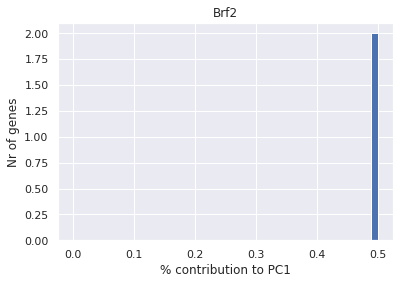

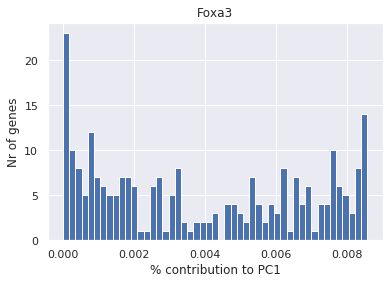

Acaa2      Acss2       Adnp       Aebp2        Aff3  \
organ dev_stage                                                            
brain -5.5        6.173406   7.398954   9.553967   44.135508   27.869818   
      -5.5      -14.923844 -10.632064  -5.351112  -13.306096  -30.906177   
      -2.5       -6.502614  -2.070749   3.474842   16.917542   -3.172222   
      -2.5       14.635490  17.485141  18.579343   75.555495   56.069206   
       0.5       -2.493257   3.146686   7.482949   32.803100   10.317323   
       0.5        5.633392  10.178471  12.775914   52.797637   31.402997   
       4.0       11.366174  16.137462  18.420881   71.779840   49.090884   
       4.0       -1.413329   4.146887   7.858648   34.970328   11.671352   
       22.0       8.505752  15.212829  14.085503   60.935266   38.796208   
       22.0      18.530082  23.609140  21.793657   88.667880   67.468164   
       29.0      33.670277  36.217417  32.701109  128.387417  110.097187   
       29.0       4.042408  11.178347  11.462985   50.888495   27.736091   
liver -5.5       14.591593   3.597688  -1.411641   -9.961433   15.492136   
      -5.5      -25.200339 -31.591636 -27.796368 -110.073781  -91.842517   
      -2.5       10.726134   3.658825  -3.099881  -12.259146    9.922208   
      -2.5        3.945651  -2.459163  -6.840686  -27.869657   -6.514431   
       0.5        0.614262  -3.912296  -8.546046  -34.142092  -14.802486   
       0.5      -24.960084 -27.401552 -24.431320  -99.050836  -83.219794   
       4.0       26.177246  19.006839  10.424222   35.618155   57.580782   
       4.0       -4.115209  -7.004119 -10.637243  -42.867518  -25.936450   
       22.0     -11.419163 -14.687342 -14.945104  -64.530125  -41.566162   
       22.0     -16.188335 -18.831974 -16.460238  -73.686735  -53.798308   
       29.0     -21.839232 -22.906799 -22.291710  -94.568733  -71.195098   
       29.0     -29.556461 -29.476993 -26.802671 -111.140510  -90.560713   

                      Aff4      Ahcy        Ahr      Aicda        Aire  ...  \
organ dev_stage                                                         ...   
brain -5.5       11.499630 -1.202348  12.004429   3.006648   30.637750  ...   
      -5.5      -23.919711  2.514787  -6.301214  -5.148272  -39.308737  ...   
      -2.5       -9.933678  1.129814   3.110068  -0.495173   -5.371629  ...   
      -2.5       27.018137 -5.168512  21.674276   7.222680   63.867726  ...   
       0.5       -1.995317  0.522770   7.662420   1.812379   10.768757  ...   
       0.5       12.017499 -3.169702  14.660762   3.855648   35.114924  ...   
       4.0       21.832254 -3.038566  20.193686   6.798651   57.462531  ...   
       4.0        0.186065 -1.706157   7.272208   0.939897   12.413064  ...   
       22.0      16.193648 -2.010792  16.532103   6.680298   46.638114  ...   
       22.0      32.833966 -4.283849  25.309459  10.473236   80.662868  ...   
       29.0      58.533521 -7.790305  38.293245  16.172320  130.791966  ...   
       29.0       9.230842 -1.525400  12.706753   4.815635   33.215694  ...   
liver -5.5       20.310209 -3.229067   0.863888  -0.269431   18.793088  ...   
      -5.5      -46.215384  6.164773 -33.344938 -15.293317 -108.484347  ...   
      -2.5       16.168565 -2.497612  -0.927470  -0.285068   12.907925  ...   
      -2.5        5.204693 -0.366741  -6.320599  -2.598272   -6.734615  ...   
       0.5       -0.592148  0.411688  -8.485374  -3.615469  -16.208518  ...   
       0.5      -44.396311  6.382420 -30.087990 -12.397079  -97.682801  ...   
       4.0       43.355747 -5.682809  13.945107   7.243571   69.807545  ...   
       4.0       -7.831875  1.002760 -12.359610  -4.914398  -28.968437  ...   
       22.0     -21.166060  4.029895 -17.328442  -3.470233  -48.057651  ...   
       22.0     -28.702877  5.271390 -20.931589  -5.015446  -62.532777  ...   
       29.0     -38.386817  6.200911 -25.407050  -6.497484  -83.350175  ...   
       29.0     -51.244595  8.040653 -32.734126  -9.021321 -106.38226

,Variance explained,Nr of genes
TF,,
Acaa2,0.525997,500
Acss2,0.532956,569
Adnp,0.436715,618
Aebp2,0.482948,9281
Aff3,0.479961,5697
...,...,...
Zic3,0.472945,2268
Zkscan1,0.474344,2633
Zmiz1,0.456745,9375


In [6]:
#Run PCA on the prepared dataframe, giving the PC values for each TF and how much of the data the the first PC explains
[PCA_per_TF, df_var_expl] = run_my_pcaX(logdata, TF_gene_sets)

In [9]:
df_var_expl.sort_values(by='Nr of genes')

,Variance explained,Nr of genes
TF,,
Yy2,1.000000,1
Glis3,1.000000,1
Atm,1.000000,1
Gcm1,1.000000,1
Bcl11a,1.000000,1
...,...,...
Spi1,0.438134,15105
Chd4,0.453589,15309
Smarca4,0.453993,15439


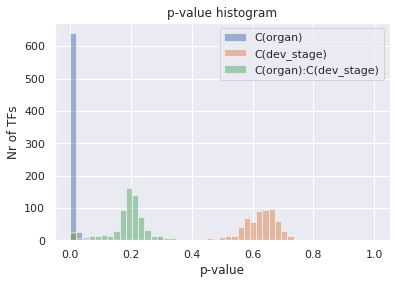

In [146]:
#Perform ANOVA
p_vals = ANOVA(PCA_per_TF)

#Plot histogram for p-value distribution inlcluding all three tested groups
for variable in p_vals.columns:
    bins = np.linspace(0,1, 50)
    plt.hist(p_vals.loc[:,variable], bins, alpha=0.5, label=variable)
plt.legend(loc='upper right')
plt.xlabel('p-value')
plt.ylabel('Nr of TFs')
plt.title('p-value histogram')
save_fig(plt,'p-value','histogram')
plt.show()


In [147]:
#Make and show dataframes with TFs with a p-value below Bonferroni corrected 0.05 for each of the groups tested
for var in p_vals.columns:
    low_p_vals = p_vals.loc[p_vals[var]<(0.05/len(p_vals))]
    low_p_vals.sort_values(by=var, inplace=True)
    display(low_p_vals)

/home/augjan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,C(organ),C(dev_stage),C(organ):C(dev_stage)
TF,,,
Foxa3,3.72205e-19,1.0459e-06,4.3679e-05
Nfil3,2.21611e-17,5.6937e-07,0.000604627
Myt1,3.60125e-17,0.0247096,0.00657099
Brwd1,4.16266e-15,0.000925628,0.0991285
Kdm5b,6.85254e-15,9.48198e-05,0.473456
...,...,...,...
Kdm5c,6.75503e-05,0.546479,0.18599
Dmrt1,7.06882e-05,0.647886,0.155783
Stat1,7.10427e-05,0.616915,0.202164


,C(organ),C(dev_stage),C(organ):C(dev_stage)
TF,,,
Rarg,9.19607e-15,1.62428e-09,0.000959054
Med23,6.92144e-10,1.9825e-08,0.00063003
Ash1l,9.70696e-09,8.38406e-08,0.00206251
Mnx1,1.06265e-10,1.12054e-07,0.00839991
Nfil3,2.21611e-17,5.6937e-07,0.000604627
Foxa3,3.72205e-19,1.0459e-06,4.3679e-05
Hnrnpk,2.81676e-09,3.48271e-06,0.000326416
Rtf1,6.53785e-07,5.52567e-06,0.00191772


,C(organ),C(dev_stage),C(organ):C(dev_stage)
TF,,,
Brf2,8.03801e-15,0.0203288,4.10402e-06
Foxa3,3.72205e-19,1.0459e-06,4.3679e-05


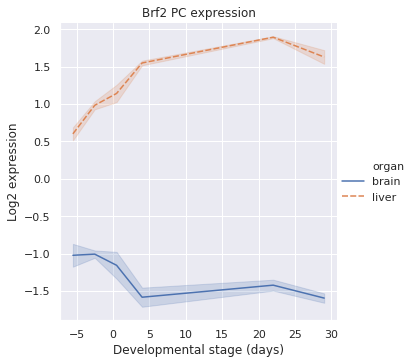

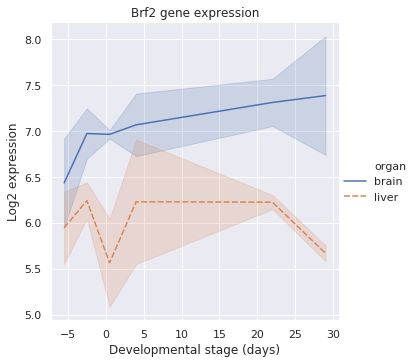

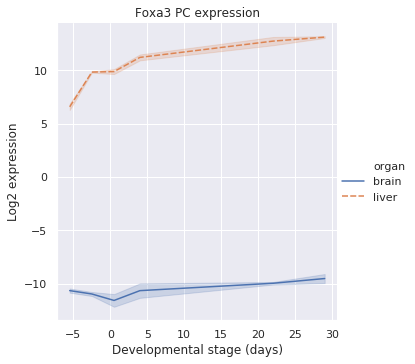

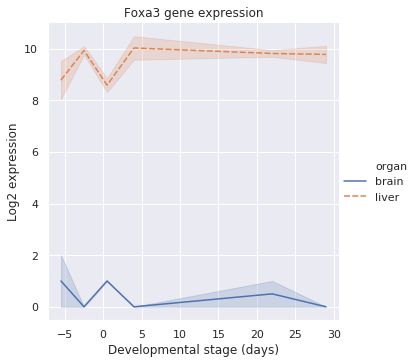

In [148]:
for TF in low_p_vals.index:
    #Plot the combined PC expression for TFs found to have a low p-valiue
    PC_plot = sns.relplot(x='dev_stage', y=TF, hue='organ', style='organ', kind='line', data=PCA_per_TF.reset_index())
    plt.xlabel('Developmental stage (days)')
    plt.ylabel('Log2 expression')
    plt.title(TF+' PC expression')
    save_fig(plt,TF,'PC')
    #Plot the gene expression for the TFs found to have a low p-value
    Gene_plot = sns.relplot(x='dev_stage', y=TF, hue='organ', style='organ', kind='line', data=logdata.T.sort_index().reset_index())
    plt.xlabel('Developmental stage (days)')
    plt.ylabel('Log2 expression')
    plt.title(TF+' gene expression')
    save_fig(plt,TF,'Gene')

In [149]:
save_exp(PCA_per_TF, 'PCA_results_1')
save_exp(df_var_expl, 'Variance_explained_1')
save_exp(p_vals,'p_vals_1')